In [1]:
import os
import glob
import datetime
import pickle
import numpy as np
import cfgrib
from scipy.ndimage import gaussian_filter
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def composit_q850WT_s2s(DailyVars, var_s, flnm_0, year_s, year_e, region_1d):
    '''
    This is for S2S June - Oct
    flnm_0 = 'q850_ano_wt_'
    '''
    #region_1d = ['Arizona_West', 'Arizona_East', 'NM_North', 'NM_South'] 
     
    n_region = len(region_1d)

    dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/WT_S2S/'
    dir_q  = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'

    n_lat = DailyVars.latitude.shape[0]
    n_lon = DailyVars.longitude.shape[0]
    n_wt = 3

    for region in region_1d:
        q850_wt = np.zeros((n_wt, n_lat, n_lon))
        count_1d = np.zeros((n_wt)) 
        flnm_o = dir_q + flnm_0 + region + '.nc'
        print(flnm_o)
        if os.path.isfile(flnm_o):
            print(flnm_o, 'exist')
        else: 
            for year in range(year_s, year_e + 1):
                flnm_wt = dir_wt + region + '/' + region + '-WTs_' + str(year) +'.cla'               
                wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
                print(flnm_wt)
                StartDay = datetime.datetime(year, MONTHS[0], 1)
                EndDay   = datetime.datetime(year, MONTHS[-1], 31)
                TimeDD   = pd.date_range(StartDay, EndDay, freq='d')
                 
                i_s = year*10000 + 601
                i_e = year*10000 + 1031
                # do label based indexing loc
                q850_0 = DailyVars.loc[i_s:i_e]
            
                for nw in wts.wt.unique(): 
                    wts_g = wts.groupby(['wt'])
                    g_ind = wts_g.get_group(nw).index
                    yyyymmdd = wts.year[g_ind]*10000 + wts.month[g_ind]*100 + wts.day[g_ind]                            
                    yyyymmdd_wt = pd.to_datetime((yyyymmdd.values), format='%Y%m%d')
                            
                    # pick WT date
                    iTime_2 = np.isin(TimeDD, yyyymmdd_wt)
                     
                    q850_np = q850_0[iTime_2].values                           
                    q850_wt[nw] = q850_wt[nw] + q850_np.sum(axis=0) 
                    count_1d[nw] = count_1d[nw] + q850_np.shape[0]

            for nw in range(n_wt):                     
                q850_wt[nw] = q850_wt[nw]/count_1d[nw]
            
            q850_xr = xr.DataArray(q850_wt, 
                                coords={'wt':range(n_wt),
                                        'latitude': DailyVars.latitude, 
                                        'longitude': DailyVars.longitude},
                                dims=['wt', 'latitude', 'longitude'],
                                attrs = {'script':'Ming Ge: AZ_S2S_qmsl_C.ipynb'})
                     
            q850_xr = q850_xr.rename(var_s) 
            print(flnm_o)
            q850_xr.to_netcdf(path = flnm_o) 
    

In [3]:
def plot_2d(lat, lon, data_2d, color_map, title_s):
    fig = plt.figure(figsize=(11,8.5))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d, cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c , orientation="horizontal", pad = 0.05); 

#### Setups

In [4]:
dir_era5 = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/' 
dir_o = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/Q850/US_large/'

In [5]:
region_1d = ['Arizona_West', 'Arizona_East', 'NM_North', 'NM_South'] 
n_region = len(region_1d)
label_wt = ['Monsoon', 'Normal', 'Dry']
n_wt = 3

lat_s = 10
lat_e = 50
lon_s = 220
lon_e = 290

MONTHS = [6,7,8,9,10]  

year_s = 1979
year_e = 2020
 
n_year = year_e - year_s + 1

In [6]:
flnm = dir_era5 + '200112/e5.oper.an.pl.128_133_q.ll025sc.2001123000_2001123023.nc'
print(flnm)

with  xr.open_dataset(flnm) as ds:
    latitude = ds.latitude.values
    longitude = ds.longitude.values
    level  = ds.level.values

# find index of targeted area    
kk = np.argmin(np.abs(850 - level)) 
j_s = np.argmin(np.abs(lon_s - longitude)) 
j_e = np.argmin(np.abs(lon_e - longitude))
i_s = np.argmin(np.abs(lat_s - latitude)) 
i_e = np.argmin(np.abs(lat_e - latitude))
print(latitude[i_s], latitude[i_e], longitude[j_s], longitude[j_e], level[kk])

/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/200112/e5.oper.an.pl.128_133_q.ll025sc.2001123000_2001123023.nc
10.0 50.0 220.0 290.0 850.0


In [7]:
# calculate/crop daily average Q850. Because it takes time, 
# I move this part to ob_array_get_q850_us.pbs get_q850_us.py to speed up
for year in range(year_s, year_s+1): 
    flnm_o = dir_o + 'q850_' + str(year) + '.nc'
     
    if os.path.isfile(flnm_o):
       print(flnm_o, 'exist')
       with  xr.open_dataset(flnm_o) as ds:
            q850_2d = ds.q850_us[0]
            #plot_2d(q850_2d.latitude, q850_2d.longitude, q850_2d, 'YlGn', 'Q850 analysis domain')
    else:
        dStartDay = datetime.datetime(year, MONTHS[0], 1, 12)
        dStopDay = datetime.datetime(year, MONTHS[-1], 31,12)
        rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d').strftime('%Y%m%d')
        yyyymmdd_int = [int(i) for i in rgdTimeDD]
        
        is_first = True
         
        for month in MONTHS:
            print(month)
            yyyymm_s = str(year*100 + month)
            # glob order is arbitrary, sort them 
            for flnm in sorted(glob.glob(dir_era5 + yyyymm_s + "/e5.oper.an.pl.128_133_q.ll025sc.*.nc")):
                print(flnm)
                with  xr.open_dataset(flnm) as ds:
                    # select 850hPa, crop to Centroid domain, daily mean
                    q850_2d = ds.Q[:,kk, i_e:i_s+1,j_s:j_e+1].mean(dim='time')
                    # concatenate daily data 
                    if is_first:
                        q850_3d = q850_2d
                        is_first = False
                    else:
                        q850_3d = xr.concat([q850_3d, q850_2d], dim="time") 
                                     
        q850_xr = xr.DataArray(q850_3d, 
                    coords={'latitude': q850_3d.latitude, 
                            'longitude': q850_3d.longitude, 
                            'time':yyyymmdd_int},
                    dims = ['time','latitude', 'longitude'],
                    attrs = {'script':'Ming Ge: q850_era5_S2S_largeDM.ipynb'})
        q850_xr = q850_xr.rename('q850_us') 
        q850_xr.to_netcdf( path = flnm_o)        

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/Q850/US_large/q850_1979.nc exist


#### calculate mean, anomaly and normalization

In [8]:
%%time
is_first = True
print(year_s, year_e)
for year in range(year_s, year_e+1):
    flnm_i = dir_o + 'q850_' + str(year) + '.nc'
    #print(flnm_i, 'exist')
    with  xr.open_dataset(flnm_i) as ds:
        q850 = ds.q850_us
        
        # concatenate annual data files 
        if is_first:
            q850_3d = q850.copy()
            is_first = False
        else:
            q850_3d = xr.concat([q850_3d, q850], dim="time") 

print(q850_3d.shape)            

1979 2020
(6426, 161, 281)
CPU times: user 4.7 s, sys: 4.91 s, total: 9.61 s
Wall time: 13.9 s


In [9]:
%%time
is_first = True
print(year_s, year_e)

dir_msl = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/MSL/US_large/'
for year in range(year_s, year_e+1):
    flnm_i = dir_msl + 'msl_' + str(year) + '.nc'
    
    with  xr.open_dataset(flnm_i) as ds:
        msl = ds.msl
        
        # concatenate annual data files 
        if is_first:
            msl_3d = msl.copy()
            is_first = False
        else:
            msl_3d = xr.concat([msl_3d, msl], dim="time") 

print(msl_3d.shape)            

1979 2020
(6426, 161, 281)
CPU times: user 4.68 s, sys: 4.92 s, total: 9.6 s
Wall time: 13.7 s


In [10]:
### NOTE Normalize data mean over time than mean

In [11]:
%%time
# Remove the annual cycle
q850_df = pd.DataFrame(q850_3d.mean(dim=('latitude', 'longitude')).values)

Averaged = np.roll(np.array(q850_df.rolling(window=21).mean()), -10, axis=0)[:,0]
Averaged[:10]  = Averaged[11] 
Averaged[-10:] = Averaged[-11] 
 
DailyVars_0 = q850_3d - Averaged[:,None,None] 

# Normalize the data
# Daily normalization
# DailyVars = (DailyVars_0-DailyVars_0.mean(dim=('latitude', 'longitude')))/DailyVars_0.std(dim=('latitude', 'longitude')) 
# Climatology
DailyVars = (DailyVars_0-DailyVars_0.mean())/DailyVars_0.std() 

# weather type
composit_q850WT_s2s(DailyVars, 'q850_ano', 'q850_ano_wt_', year_s, year_e, region_1d)

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_Arizona_West.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_Arizona_West.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_Arizona_East.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_NM_North.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_NM_North.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_NM_South.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_NM_South.nc exist
CPU times: user 4.28 s, sys: 2.26 s, total: 6.54 s
Wall time: 6.67 s


##### weather type
 

In [12]:
%%time
# Remove the annual cycle
msl_df = pd.DataFrame(msl_3d.mean(dim=('latitude', 'longitude')).values)

Averaged = np.roll(np.array(msl_df.rolling(window=21).mean()), -10, axis=0)[:,0]
Averaged[:10]  = Averaged[11] 
Averaged[-10:] = Averaged[-11] 
 
DailyVars_0 = msl_3d - Averaged[:,None,None] 

# Normalize the data
# Daily normalization
# DailyVars = (DailyVars_0-DailyVars_0.mean(dim=('latitude', 'longitude')))/DailyVars_0.std(dim=('latitude', 'longitude')) 
# Climatology
DailyVars = (DailyVars_0-DailyVars_0.mean())/DailyVars_0.std() 

# weather type
composit_q850WT_s2s(DailyVars, 'msl_ano', 'msl_ano_wt_', year_s, year_e, region_1d)

/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_Arizona_West.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_Arizona_West.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_Arizona_East.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_Arizona_East.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_NM_North.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_NM_North.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_NM_South.nc
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_NM_South.nc exist
CPU times: user 3.99 s, sys: 2.62 s, total: 6.61 s
Wall time: 6.8 s


/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_West.shp
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_East.shp
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_North.shp
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_South.shp


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/284811146.py:65: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


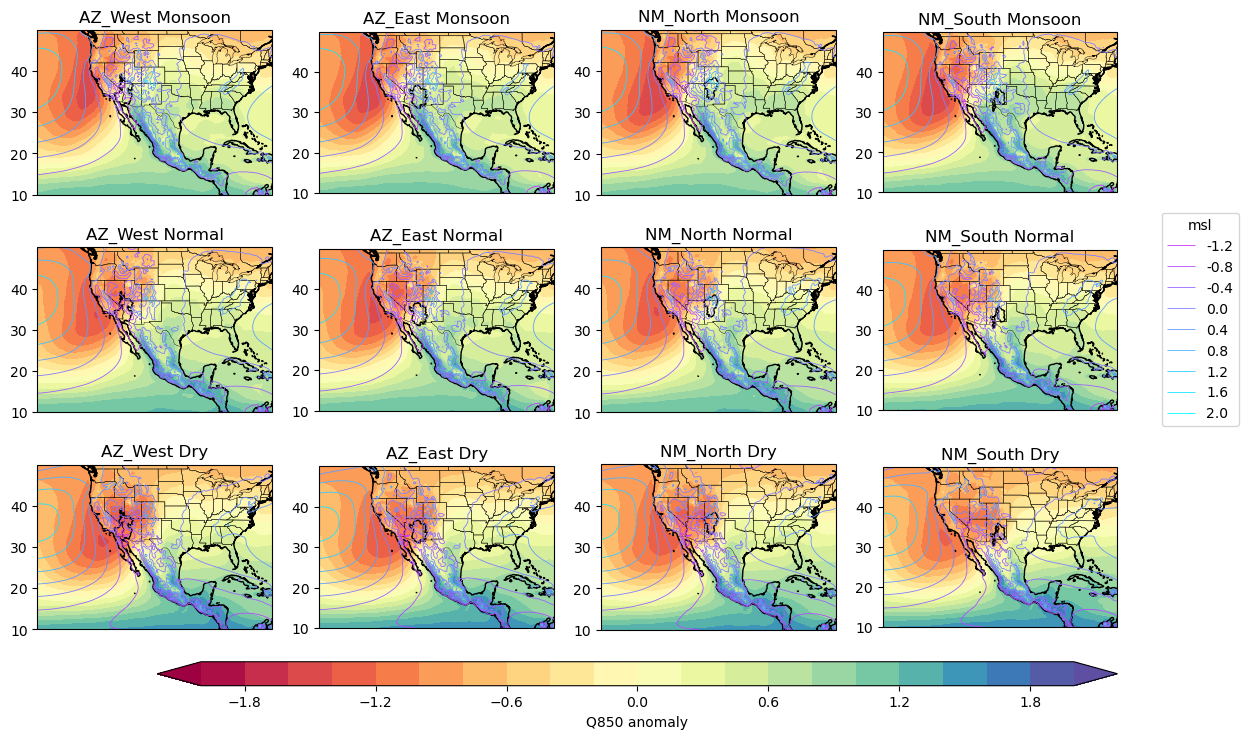

In [13]:
proj = ccrs.PlateCarree()

    
# Set up a standard map for latlon data for multiple subplots
fig, ax = plt.subplots(n_wt, n_region,figsize=(16,8), subplot_kw={'projection': proj})

levels = np.linspace(-2., 2., 21) 

dir_q  = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
dir_shp = '/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/'

lat_1d = ds.latitude
lon_1d = ds.longitude

for nr in range(n_region):
    region = region_1d[nr]
    flnm_o = dir_q + 'q850_ano_wt_' + region + '.nc'
    flnm_msl = dir_q + 'msl_ano_wt_' + region + '.nc'
    region = region.replace('Arizona','AZ')
    # load shapefile
    print(dir_shp + region + '.shp')
    shp_gpd = gpd.read_file(dir_shp + region + '.shp')
     
     
    with xr.open_dataset(flnm_o) as ds:
        q850_wt = ds.q850_ano
    
    with xr.open_dataset(flnm_msl) as ds_msl:
        msl_wt = ds_msl.msl_ano
        
    for nw in range(n_wt):
         # Make a filled contour plot
        
        cntr     = ax[nw,nr].contour(msl_wt.longitude, msl_wt.latitude, msl_wt[nw], cmap = 'cool_r', linewidths=.6, levels=7, vmin=-2, vmax=2)
        filled_c = ax[nw, nr].contourf(q850_wt.longitude, q850_wt.latitude, q850_wt[nw], extend='both',
                                       levels = levels, cmap = 'Spectral', transform = ccrs.PlateCarree())
        
        # Add coastlines
        ax[nw, nr].coastlines()
        ax[nw, nr].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
        ax[nw, nr].set_title(region + ' ' + label_wt[nw])

        # plot the lat lon labels
        #xticks = np.arange(lon_1d.min(), lon_1d.max(), 2) 
        #yticks = np.arange(lat_1d.min(), lat_1d.max(), 2)  
        xticks = np.arange(int(lon_1d.min()), int(lon_1d.max()), 10) 
        yticks = np.arange(int(lat_1d.min()), int(lat_1d.max()), 10)  
        ax[nw, nr].set_xticks(xticks, crs=cartopy.crs.PlateCarree())
        ax[nw, nr].set_yticks(yticks, crs=cartopy.crs.PlateCarree())
        
        # add shapefile outline
        shp_gpd.plot(ax = ax[nw,nr], edgecolor='black', color='none', linewidth=1)
        #ax[nw, nr].set_xlim(lon_1d.min(), lon_1d.max())
        #ax[nw, nr].set_ylim(lat_1d.min(), lat_1d.max())

        # Add a colorbar for the filled contour.
        # and pad argument to set colorbar away from x-axis
        #fig.colorbar(filled_c , orientation="horizontal", pad = 0.1);
        
fig.subplots_adjust(right=0.8)
# rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar_ax.set_label('anomaly') #rotation=270)
 
clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')
clb.set_label('Q850 anomaly')

h = cntr.collections
l = [f'{a:.1f}' for a in cntr.levels]
# bbox_to_anchor is used to specify the coordinates of the legend,
fig.legend(h,l, bbox_to_anchor =(0.88, 0.65), title='msl')

#### anomaly use small centroid area
- calculate centroid domain mean, std

In [14]:
%%time
is_first = True
print(year_s, year_e)
for year in range(year_s, year_e+1):
    flnm_i = dir_o + 'q850_' + str(year) + '.nc'
    #print(flnm_i, 'exist')
    with  xr.open_dataset(flnm_i) as ds:
        q850 = ds.q850_us
        
        # concatenate annual data files 
        if is_first:
            q850_3d = q850.copy()
            is_first = False
        else:
            q850_3d = xr.concat([q850_3d, q850], dim="time") 
            
# Remove the annual cycle
q850_df = pd.DataFrame(q850_3d.mean(dim=('latitude', 'longitude')).values)

Averaged = np.roll(np.array(q850_df.rolling(window=21).mean()), -10, axis=0)[:,0]
Averaged[:10]  = Averaged[11] 
Averaged[-10:] = Averaged[-11] 
 
DailyVars_q850 = q850_3d - Averaged[:,None,None] 

1979 2020
CPU times: user 5.51 s, sys: 5.55 s, total: 11.1 s
Wall time: 14.4 s


In [15]:
%%time
is_first = True
print(year_s, year_e)
for year in range(year_s, year_e+1):
    flnm_i = dir_msl + 'msl_' + str(year) + '.nc'
     
    with  xr.open_dataset(flnm_i) as ds:
        msl = ds.msl
        
        # concatenate annual data files 
        if is_first:
            msl_3d = msl.copy()
            is_first = False
        else:
            msl_3d = xr.concat([msl_3d, msl], dim="time") 
            
# Remove the annual cycle
msl_df = pd.DataFrame(msl_3d.mean(dim=('latitude', 'longitude')).values)

Averaged = np.roll(np.array(msl_df.rolling(window=21).mean()), -10, axis=0)[:,0]
Averaged[:10]  = Averaged[11] 
Averaged[-10:] = Averaged[-11] 
 
DailyVars_msl = msl_3d - Averaged[:,None,None] 

1979 2020
CPU times: user 5.38 s, sys: 5.6 s, total: 11 s
Wall time: 14.6 s


31.5 44.25 lon 240.0 252.0
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_West.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_Arizona_West.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_Arizona_West.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1964311245.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


30.0 41.25 lon 243.75 255.75
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_East.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_Arizona_East.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_Arizona_East.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1964311245.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


34.5 39.75 lon 249.0 254.25
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_North.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_NM_North.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_NM_North.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1964311245.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


30.75 37.5 lon 252.75 257.25
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_South.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_NM_South.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_NM_South.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1964311245.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


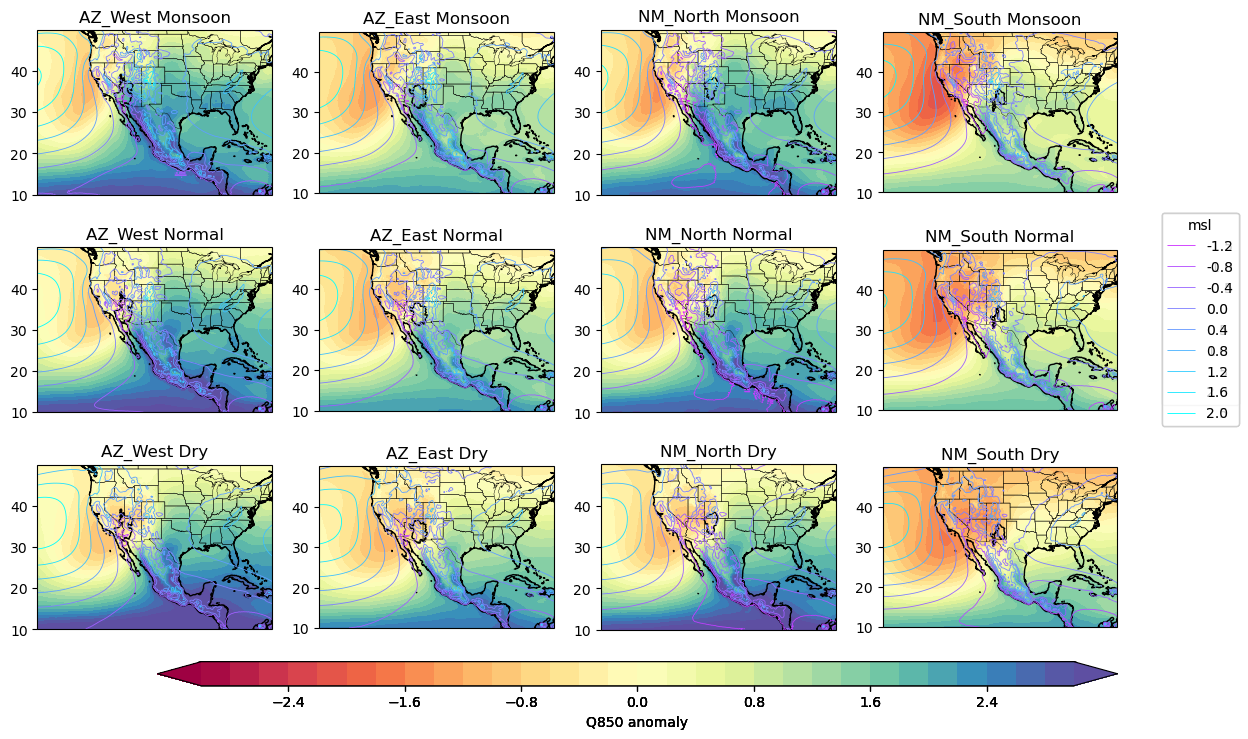

In [16]:
dir_q  = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
dir_shp = '/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/'
dir_data = '/glade/campaign/mmm/c3we/mingge/COEXIST/AZ_S2S_DATA/'

lat_1d = ds.latitude
lon_1d = ds.longitude

fig, ax = plt.subplots(n_wt, n_region,figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
levels = np.linspace(-3, 3, 31) 

for nr in range(n_region): 
    if region_1d[nr] == 'Arizona_West':
        sWTdata = dir_data + 'Clusters13514_1501_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'Arizona_East':
        sWTdata = dir_data + 'Clusters13514_1502_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'NM_North':
        sWTdata = dir_data + 'Clusters13514_HUC6-00_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'NM_South':
        sWTdata = dir_data + 'Clusters13514_HUC6-03_1982-2018_Q850_JJASO'
        
    # Load the Centroids
    with open(sWTdata, 'rb') as handle:
        npzfile = pickle.load(handle)
    
        WTclusters=npzfile['grClustersFin']['Full']
        WTlat=npzfile['LatWT']     
        WTlon=npzfile['LonWT'] 

        # WTlon[WTlon<0] = WTlon[WTlon<0]+360
        lat_s = min(WTlat[:, 0])
        lat_e = max(WTlat[:, 0])
        lon_s = 360 + min(WTlon[0, :])
        lon_e = 360 + max(WTlon[0, :])
        print(lat_s, lat_e, 'lon', lon_s, lon_e)
        
        q850_sm_3d = DailyVars_q850.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e)) 
        msl_sm_3d  = DailyVars_msl.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e))             


        # Climatoloty normalization
        mean_sm_1d = q850_sm_3d.mean().values
        std_sm_1d  = q850_sm_3d.std().values 
        DailyVars_q850 = (DailyVars_q850 - mean_sm_1d)/std_sm_1d 
        
        mean_sm_1d = msl_sm_3d.mean().values
        std_sm_1d  = msl_sm_3d.std().values 
        DailyVars_msl = (DailyVars_msl - mean_sm_1d)/std_sm_1d 
        
    region = region_1d[nr]
    region = region.replace('Arizona','AZ')
 
    print(dir_shp + region + '.shp')
    shp_gpd = gpd.read_file(dir_shp + region + '.shp')
     
    flnm_o   = dir_q + 'q850_ano_wt_sm_' + region_1d[nr] + '.nc'
    flnm_msl = dir_q + 'msl_ano_wt_sm_' + region_1d[nr] + '.nc'
    
    if not os.path.isfile(flnm_o):
        composit_q850WT_s2s(DailyVars_q850, 'q850_ano', 'q850_ano_wt_sm_', year_s, year_e, [region_1d[nr]])
    elif not os.path.isfile(flnm_msl):
        composit_q850WT_s2s(DailyVars_msl, 'msl_ano', 'msl_ano_wt_sm_', year_s, year_e, [region_1d[nr]])
    else:
        with  xr.open_dataset(flnm_o) as ds:
            print('flnm', flnm_o)
            q850_wt = ds.q850_ano #.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e))
        
        with xr.open_dataset(flnm_msl) as ds:
            print('flnm', flnm_msl)
            msl_wt = ds.msl_ano
            
        for nw in range(n_wt):
                cntr     = ax[nw,nr].contour(msl_wt.longitude, msl_wt.latitude, msl_wt[nw], cmap = 'cool_r', linewidths=.6, levels=7, vmin=-2, vmax=2)
                filled_c = ax[nw, nr].contourf(q850_wt.longitude, q850_wt.latitude, q850_wt[nw], extend='both',
                                       levels = levels, cmap = 'Spectral', transform = ccrs.PlateCarree())
        
                # Add coastlines
                ax[nw, nr].coastlines()
                ax[nw, nr].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
                ax[nw, nr].set_title(region + ' ' + label_wt[nw])

                xticks = np.arange(int(lon_1d.min()), int(lon_1d.max()), 10) 
                yticks = np.arange(int(lat_1d.min()), int(lat_1d.max()), 10)  
                ax[nw, nr].set_xticks(xticks, crs=cartopy.crs.PlateCarree())
                ax[nw, nr].set_yticks(yticks, crs=cartopy.crs.PlateCarree())
        
                # add shapefile outline
                shp_gpd.plot(ax = ax[nw,nr], edgecolor='black', color='none', linewidth=1)
        
        fig.subplots_adjust(right=0.8)
        # rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
        cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
        cbar_ax.set_label('anomaly') #rotation=270)
 
        clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')
        clb.set_label('Q850 anomaly');
        
        h = cntr.collections
        l = [f'{a:.1f}' for a in cntr.levels]
        # bbox_to_anchor is used to specify the coordinates of the legend,
        fig.legend(h,l, bbox_to_anchor =(0.88, 0.65), title='msl')

#### with different color map

31.5 44.25 lon 240.0 252.0
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_West.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_Arizona_West.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_Arizona_West.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/2900217919.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


30.0 41.25 lon 243.75 255.75
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_East.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_Arizona_East.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_Arizona_East.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/2900217919.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


34.5 39.75 lon 249.0 254.25
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_North.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_NM_North.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_NM_North.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/2900217919.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


30.75 37.5 lon 252.75 257.25
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_South.shp
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_NM_South.nc
flnm /glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/msl_ano_wt_sm_NM_South.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/2900217919.py:94: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


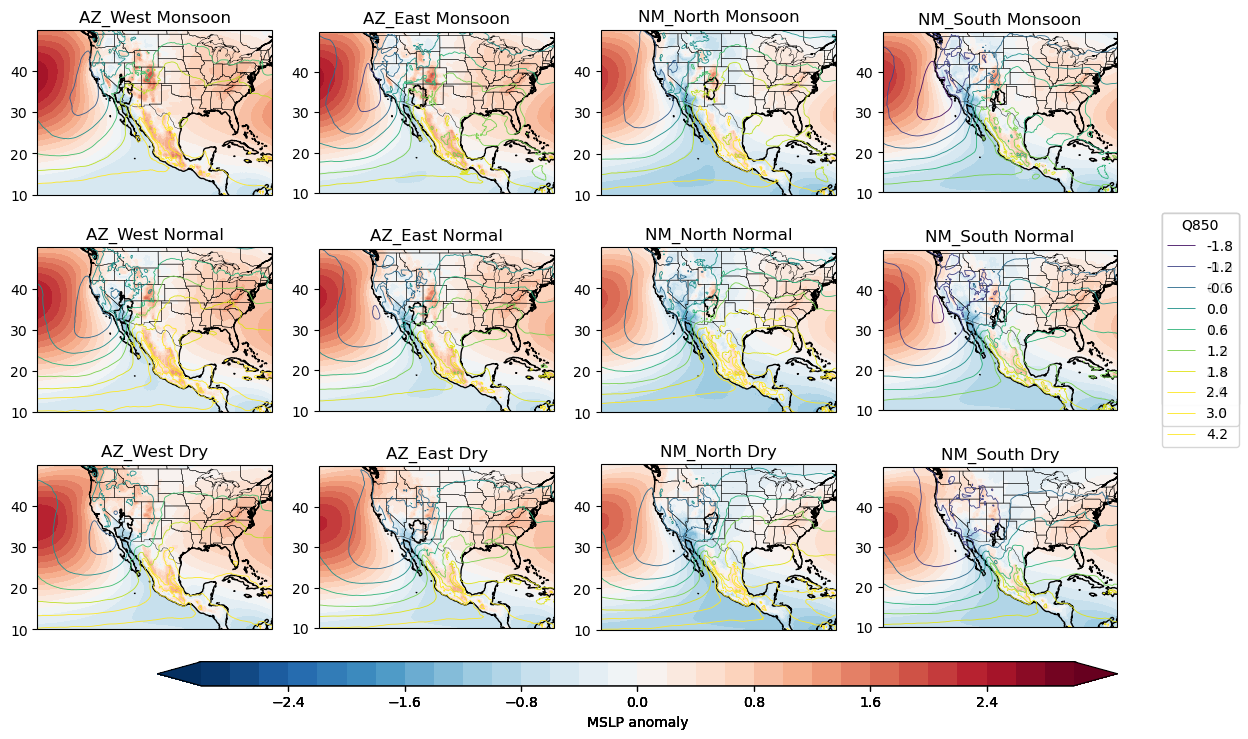

In [19]:
dir_q  = '/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/'
dir_shp = '/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/'
dir_data = '/glade/campaign/mmm/c3we/mingge/COEXIST/AZ_S2S_DATA/'

lat_1d = ds.latitude
lon_1d = ds.longitude

fig, ax = plt.subplots(n_wt, n_region,figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
levels = np.linspace(-3, 3, 31) 

for nr in range(n_region): 
    if region_1d[nr] == 'Arizona_West':
        sWTdata = dir_data + 'Clusters13514_1501_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'Arizona_East':
        sWTdata = dir_data + 'Clusters13514_1502_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'NM_North':
        sWTdata = dir_data + 'Clusters13514_HUC6-00_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'NM_South':
        sWTdata = dir_data + 'Clusters13514_HUC6-03_1982-2018_Q850_JJASO'
        
    # Load the Centroids
    with open(sWTdata, 'rb') as handle:
        npzfile = pickle.load(handle)
    
        WTclusters=npzfile['grClustersFin']['Full']
        WTlat=npzfile['LatWT']     
        WTlon=npzfile['LonWT'] 

        # WTlon[WTlon<0] = WTlon[WTlon<0]+360
        lat_s = min(WTlat[:, 0])
        lat_e = max(WTlat[:, 0])
        lon_s = 360 + min(WTlon[0, :])
        lon_e = 360 + max(WTlon[0, :])
        print(lat_s, lat_e, 'lon', lon_s, lon_e)
        
        q850_sm_3d = DailyVars_q850.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e)) 
        msl_sm_3d  = DailyVars_msl.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e))             


        # Climatoloty normalization
        mean_sm_1d = q850_sm_3d.mean().values
        std_sm_1d  = q850_sm_3d.std().values 
        DailyVars_q850 = (DailyVars_q850 - mean_sm_1d)/std_sm_1d 
        
        mean_sm_1d = msl_sm_3d.mean().values
        std_sm_1d  = msl_sm_3d.std().values 
        DailyVars_msl = (DailyVars_msl - mean_sm_1d)/std_sm_1d 
        
    region = region_1d[nr]
    region = region.replace('Arizona','AZ')
 
    print(dir_shp + region + '.shp')
    shp_gpd = gpd.read_file(dir_shp + region + '.shp')
     
    flnm_o   = dir_q + 'q850_ano_wt_sm_' + region_1d[nr] + '.nc'
    flnm_msl = dir_q + 'msl_ano_wt_sm_' + region_1d[nr] + '.nc'
    
    if not os.path.isfile(flnm_o):
        composit_q850WT_s2s(DailyVars_q850, 'q850_ano', 'q850_ano_wt_sm_', year_s, year_e, [region_1d[nr]])
    elif not os.path.isfile(flnm_msl):
        composit_q850WT_s2s(DailyVars_msl, 'msl_ano', 'msl_ano_wt_sm_', year_s, year_e, [region_1d[nr]])
    else:
        with  xr.open_dataset(flnm_o) as ds:
            print('flnm', flnm_o)
            q850_wt = ds.q850_ano #.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e))
        
        with xr.open_dataset(flnm_msl) as ds:
            print('flnm', flnm_msl)
            msl_wt = ds.msl_ano
            
        for nw in range(n_wt):
                cntr     = ax[nw,nr].contour(q850_wt.longitude, q850_wt.latitude, q850_wt[nw], cmap = 'viridis', linewidths=.6, levels=7, vmin=-2, vmax=2)
                filled_c = ax[nw, nr].contourf(msl_wt.longitude, msl_wt.latitude, msl_wt[nw], extend='both',
                                       levels = levels, cmap = 'RdBu_r', transform = ccrs.PlateCarree())
        
                # Add coastlines
                ax[nw, nr].coastlines()
                ax[nw, nr].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
                ax[nw, nr].set_title(region + ' ' + label_wt[nw])

                xticks = np.arange(int(lon_1d.min()), int(lon_1d.max()), 10) 
                yticks = np.arange(int(lat_1d.min()), int(lat_1d.max()), 10)  
                ax[nw, nr].set_xticks(xticks, crs=cartopy.crs.PlateCarree())
                ax[nw, nr].set_yticks(yticks, crs=cartopy.crs.PlateCarree())
        
                # add shapefile outline
                shp_gpd.plot(ax = ax[nw,nr], edgecolor='black', color='none', linewidth=1)
        
        fig.subplots_adjust(right=0.8)
        # rect : This parameter is the dimen
        cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
        cbar_ax.set_label('anomaly') #rotation=270)
 
        clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')
        clb.set_label('MSLP anomaly');
        
        h = cntr.collections
        l = [f'{a:.1f}' for a in cntr.levels]
        # bbox_to_anchor is used to specify the coordinates of the legend,
        fig.legend(h,l, bbox_to_anchor =(0.88, 0.65), title='Q850')

31.5 44.25 lon 240.0 252.0
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_West.shp
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_Arizona_West.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1274533609.py:82: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


30.0 41.25 lon 243.75 255.75
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/AZ_East.shp
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_Arizona_East.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1274533609.py:82: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


34.5 39.75 lon 249.0 254.25
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_North.shp
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_NM_North.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1274533609.py:82: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


30.75 37.5 lon 252.75 257.25
/glade/u/home/prein/projects/Arizona_WTing/Shapefiles/NM_South.shp
/glade/campaign/mmm/c3we/mingge/COEXIST/ERA5/q850_ano_wt_sm_NM_South.nc


/glade/derecho/scratch/mingge/tmp/ipykernel_51123/1274533609.py:82: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')


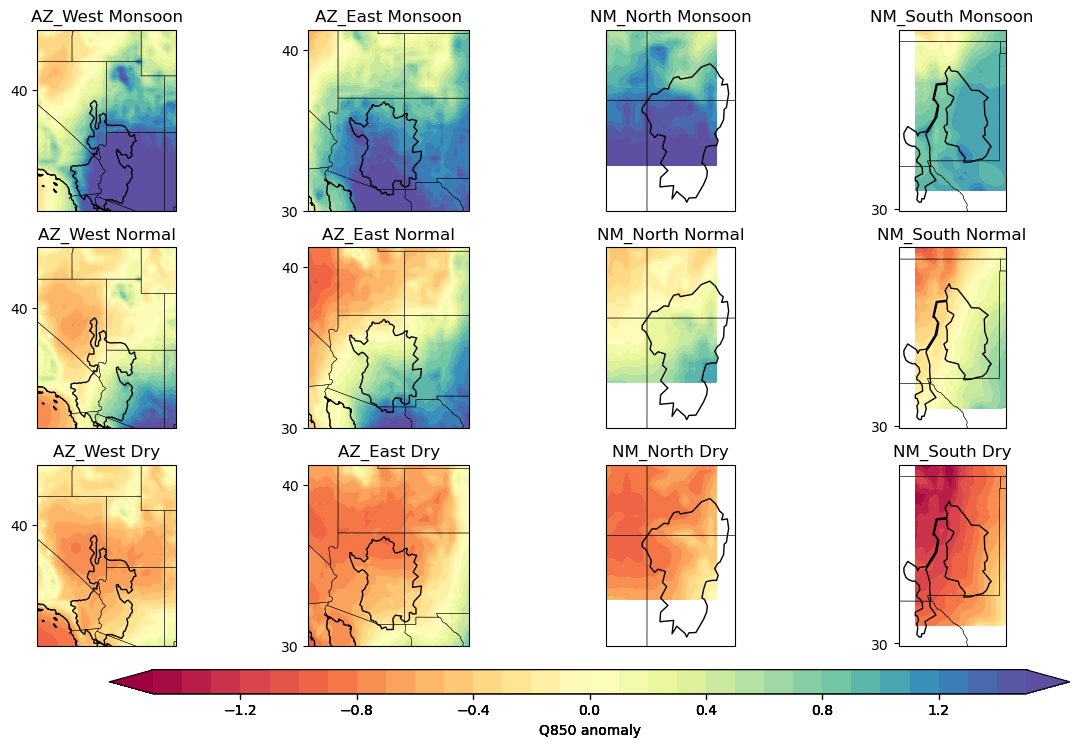

In [17]:
fig, ax = plt.subplots(n_wt, n_region,figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
levels = np.linspace(-1.5, 1.5, 31) 

for nr in range(n_region): 
    if region_1d[nr] == 'Arizona_West':
        sWTdata = dir_data + 'Clusters13514_1501_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'Arizona_East':
        sWTdata = dir_data + 'Clusters13514_1502_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'NM_North':
        sWTdata = dir_data + 'Clusters13514_HUC6-00_1982-2018_Q850_JJASO'
    if region_1d[nr] == 'NM_South':
        sWTdata = dir_data + 'Clusters13514_HUC6-03_1982-2018_Q850_JJASO'
        
    # Load the Centroids
    with open(sWTdata, 'rb') as handle:
        npzfile = pickle.load(handle)
    
        WTclusters=npzfile['grClustersFin']['Full']
        WTlat=npzfile['LatWT']     
        WTlon=npzfile['LonWT'] 

        # WTlon[WTlon<0] = WTlon[WTlon<0]+360
        lat_s = min(WTlat[:, 0])
        lat_e = max(WTlat[:, 0])
        lon_s = 360 + min(WTlon[0, :])
        lon_e = 360 + max(WTlon[0, :])
        print(lat_s, lat_e, 'lon', lon_s, lon_e)
        
        # Remove the annual cycle
        q850_df = pd.DataFrame(q850_3d.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e)).mean(dim=('latitude', 'longitude')).values)
 
        Averaged = np.roll(np.array(q850_df.rolling(window=21).mean()), -10, axis=0)[:,0]
         
        Averaged[:10]  = Averaged[11] 
        Averaged[-10:] = Averaged[-11] 
        DailyVars_sm = q850_3d - Averaged[:,None,None] 
        
        q850_sm_3d = DailyVars_sm.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e))       
        
        mean_sm_1d = q850_sm_3d.mean(dim=('latitude', 'longitude')).values
        std_sm_1d  = q850_sm_3d.std(dim=('latitude', 'longitude')).values 
        DailyVars_sm = (DailyVars_sm - mean_sm_1d[:, None, None])/std_sm_1d[:, None, None]  
        
    region = region_1d[nr]
    region = region.replace('Arizona','AZ')
 
    print(dir_shp + region + '.shp')
    shp_gpd = gpd.read_file(dir_shp + region + '.shp')
     
    flnm_o = dir_q + 'q850_ano_wt_sm_' + region_1d[nr] + '.nc'
    
    if not os.path.isfile(flnm_o):
        composit_q850WT_s2s(DailyVars_sm, 'q850_ano_wt_sm_', year_s, year_e, [region_1d[nr]])
        continue
    else:
        with  xr.open_dataset(flnm_o) as ds:
            print(flnm_o)
            q850_wt = ds.q850_ano.sel(latitude=slice(lat_e, lat_s), longitude=slice(lon_s, lon_e))
        
            for nw in range(n_wt):
                filled_c = ax[nw, nr].contourf(q850_wt.longitude, q850_wt.latitude, q850_wt[nw], extend='both',
                                       levels = levels, cmap = 'Spectral', transform = ccrs.PlateCarree())
        
                # Add coastlines
                ax[nw, nr].coastlines()
                ax[nw, nr].add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
                ax[nw, nr].set_title(region + ' ' + label_wt[nw])

                xticks = np.arange(int(lon_1d.min()), int(lon_1d.max()), 10) 
                yticks = np.arange(int(lat_1d.min()), int(lat_1d.max()), 10)  
                ax[nw, nr].set_xticks(xticks, crs=cartopy.crs.PlateCarree())
                ax[nw, nr].set_yticks(yticks, crs=cartopy.crs.PlateCarree())
        
                # add shapefile outline
                shp_gpd.plot(ax = ax[nw,nr], edgecolor='black', color='none', linewidth=1)
        
        fig.subplots_adjust(right=0.8)
        # rect : This parameter is the dimensions [left, bottom, width, height] of the new axes.
        cbar_ax = fig.add_axes([0.2, 0.05, 0.6, 0.03])
        cbar_ax.set_label('anomaly') #rotation=270)
 
        clb = fig.colorbar(filled_c, cax=cbar_ax, extend='both', orientation='horizontal')
        clb.set_label('Q850 anomaly');
        